# Practical Session 4 - Deep Learning with PyTorch
In this session we will start with our toy task again.
Remember how we solved it with an MLP in the first class ?
We used scikit-learn, a one-liner but without control over what was happening.

We will start by implementing the model in Pytorch, in a basic way.

Then we will work our way to making our code looks like a real Pytorch code.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

np.random.seed(20)


def base_function(x):
    y = 1.3 * x ** 3 - 3 * x ** 2 + 3.6 * x + 6.9
    return y

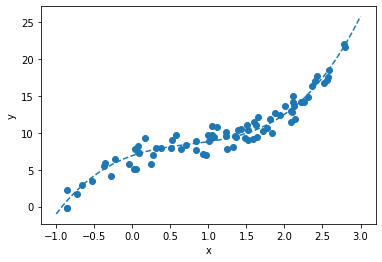

In [3]:

low, high = -1, 3
n_points = 80

# Get the values
xs = np.random.uniform(low, high, n_points)
ys_noise = np.random.normal(size=len(xs))
sample_ys = base_function(xs)
noisy_sample_ys = sample_ys + ys_noise

# Plot the hidden function
lsp = np.linspace(low, high)
true_ys = base_function(lsp)
plt.plot(lsp, true_ys, linestyle='dashed')

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We used the following command to fit the regressor last time :
"from sklearn.neural_network import MLPRegressor
 mlp_model = MLPRegressor(max_iter=5000)"

By default, the MLP Regressor makes the following computational graph :
- input gets multiplied by a matrix with 100 parameters, and an additional parameter is added to each values, giving 100 outputs y (shape = (n_samples, 100))
- ReLU is applied to each of these outputs (shape = (n_samples, 100)). The relu function is implemented in PyTorch with torch.nn.functional.relu(x)
- Then this value is multiplied by a matrix to produce a scalar output (again 100 parameters) (shape = (n_samples, 1)) and shifted by an offset.

A quick reminder on matrix multiplication : it is an operation that combines one matrix A of shape (m,n) and a matrix B of shape (n,p) into a matrix C of shape (m,p). In PyTorch (and NumPy), you need to call torch.matmul(A,B) to make this computation.

To make the two big multiplications, we will use one torch tensor of 100 parameters for each multiplication, with the appropriate shape.Create random starting tensors of parameters.

Then implement the asked computation to produce our output from our input. You should debug the operations by ensuring the shapes are correct.

In [4]:
# First create the parameters with small random initial values.
# We need to mention that we want to compute a gradient
# I provide you with the example for the first one, fill the others :
w1 = torch.normal(mean=0., std=0.1, size=(1, 100), requires_grad=True)
b1 = 0
w2 = 0
b2 = 0

In [5]:
# Then define the function
def f(x, weight1=w1, bias1=b1, weight2=w2, bias2=b2):
    out = torch.tensor(0)  # Replace this with the actual output
    return out


# Just to be sure everything runs, we make an inference on an example input of 6 random values
sample_input = torch.ones(size=(6, 1))
f(sample_input).shape

torch.Size([])

Now we will mostly use last class optimization procedure to train our network using Pytorch
Fill out the learning loop, inspired by last time's class.
Then plot the resulting model

In [6]:
# Also set up the data
# Check that when doing inference on the data, we get an output tensor of shape (80,1)
# Call us if it is not the case, there is something ~ subtle and not interesting
torch_xs = torch.from_numpy(xs)[:, None]
torch_noisy_ys = torch.from_numpy(noisy_sample_ys)[:, None]
f(torch_xs).shape

torch.Size([])

In [7]:
# Now like last time, let us define an optimizer and give the parameters to it.
n_iter = 2000
opt = torch.optim.Adam([w1, b1, w2, b2], lr=0.01)

TypeError: optimizer can only optimize Tensors, but one of the params is int

In [8]:
# Loop over the data, make the forward, backward, step and zero grad
for i in range(n_iter):
    pass
    # if not i % 10:
    #     print(i, loss.item())

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

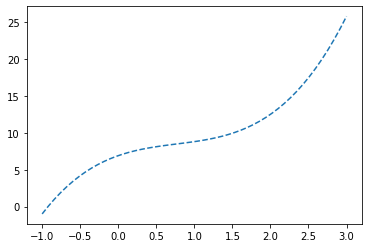

In [9]:
torch_lsp = torch.from_numpy(lsp).float()[:, None]
predicted_ys = f(torch_lsp).detach().numpy()

plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Congratulations, you have coded yourself a MLP model ! We have used the computation graph framework.


Now let us make our code prettier (more Pytorch) and more efficient.
First let us refactor the model in the proper way it should be coded, by using the torch.nn.Module class.
You should add almost no new code, just reorganize the one above into a class.

In [10]:
from torch.nn import Module, Parameter


class MyOwnMLP(Module):
    def __init__(self):
        super(MyOwnMLP, self).__init__()
        self.w1 = Parameter(torch.normal(mean=0., std=0.1, size=(1, 100)))
        # ...

    def forward(self, x):
        # Define the forward pass (computation graph) like above
        return out


model = MyOwnMLP()
out = model(torch_xs)
out.shape

NameError: name 'out' is not defined

Now we are good to also make the data iteration process look like Pytorch code !

We need to define a Dataset object. Once we have this, we can use it to create a DataLoader object

In [11]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data_x, data_y):
        pass
        # store the data

    def __len__(self):
        pass
        # Return the number of points in your dataset

    def __getitem__(self, index):
        # Get the x and y at a given position (index) in the data
        x = 0
        y = 0
        return x, y

In [12]:
# Loop and wait for each data point in PyTorch
dataset = CustomDataset(data_x=torch_xs, data_y=torch_noisy_ys)
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=6)
start = time.time()
for point in dataloader:
    pass
print('Done in pytorch : ', time.time() - start)

TypeError: 'NoneType' object cannot be interpreted as an integer

The last thing missing to make our pipeline truly Pytorch is to use a GPU.

In Pytorch it is really easy, you just need to 'move' your tensors to a 'device'.
You can test if a gpu is available and create the appropriate device with the following lines:

In [13]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
torch_xs = torch_xs.to(device)

Now we finally have all the elements to make an actual Pytorch complete pipeline !

Create a model, and try to put it on a device.
Create an optimizer with your model's parameters
Make your data into a dataloader

Then use two nested for loops : one for 100 epochs, and in each epoch loop over the dataloader
    Inside the loop, for every batch first put the data on the device
    Then use the semantics of above :
        - model(batch)
        - loss computation and backward
        - gradient step and zero_grad

In [14]:
n_epochs = 200

for epoch in range(n_epochs):
    for batch_x, batch_y in dataloader:
        # Don't forget to send to device, the rest is similar to what we had above
        pass

# To easily use the trained model we need to send it back to cpu at the end
model = model.to('cpu')

TypeError: 'NoneType' object cannot be interpreted as an integer

We finally can plot the last model

In [16]:
predicted_ys = model(torch_lsp).detach().numpy()

plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

NameError: name 'out' is not defined